In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from ImplicitDenoising import *

np.random.seed(1)

#
#
noise_percent = 100
#
#

Populating the interactive namespace from numpy and matplotlib


/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def Lorenz(X,params = (10,28,8/3)):
    """
    Time derivative of Lorenz equation
    """
    
    sigma,rho,beta = params
    m = tf.shape(X).eval()[1]
    
    x = tf.slice(X, [0,0], [1,m])
    y = tf.slice(X, [1,0], [1,m])
    z = tf.slice(X, [2,0], [1,m])
    
    X_t = tf.concat([sigma*(y-x), \
                   x*(rho-z)-y, \
                   x*y-beta*z],axis=0)
    
    return X_t

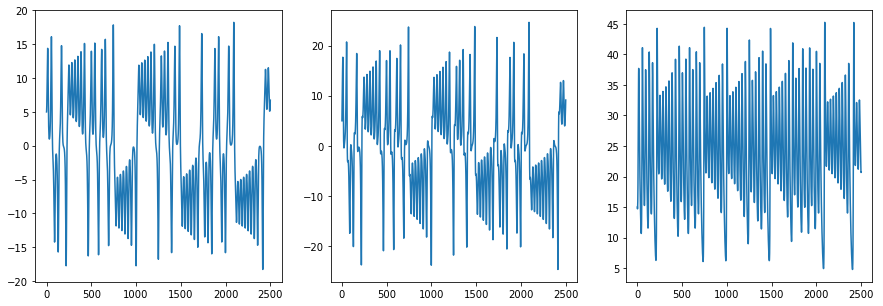

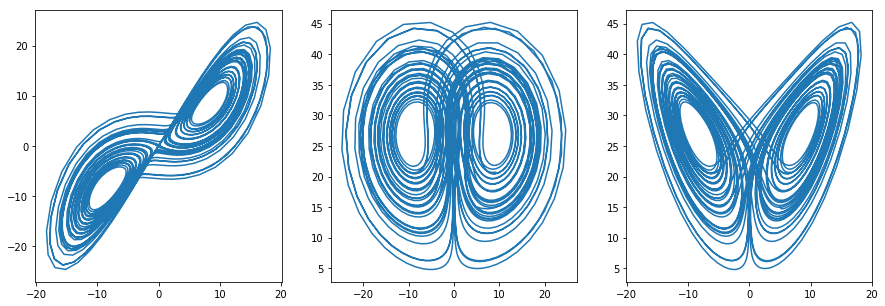

In [3]:
def lorenz_ode(X, t, params):
    s,r,b = params
    x,y,z = X
    return [s*(y-x), x*(r-z)-y, x*y-b*z]

M = 25000
subsample_rate = 10

subsample = [j for j in range(M) if j%subsample_rate == 0]
m = len(subsample)

t = np.linspace(0,50,M); dt = (t[1]-t[0])*subsample_rate


params = (10,28,8.0/3)
X = odeint(lorenz_ode, [5,5,15], t, args=(params,), rtol = 1e-12, atol = 1e-12)[subsample, :].T
x = X[0,:]; y = X[1,:]; z = X[2,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(x)
subplot(1,3,2); plot(y)
subplot(1,3,3); plot(z)
figure()
subplot(1,3,1); plot(x, y)
subplot(1,3,2); plot(y, z)
subplot(1,3,3); plot(x, z)

In [4]:
n = X.shape[0]
noise_level = 0.01*noise_percent*np.var(X) 
measurement_noise_gaussian = np.sqrt(noise_level)*np.random.randn(n,m)

# Try red noise
r = 0.#75
measurement_noise = np.zeros_like(measurement_noise_gaussian)
measurement_noise[:,0] = measurement_noise_gaussian[:,0]
for j in range(1,m): measurement_noise[:,j] = r*measurement_noise[:,j-1] + \
                                              (1-r**2)**0.5*measurement_noise_gaussian[:,j]

measurement_noise[0,:] = measurement_noise[0,:] + 5
measurement_noise[1,:] = measurement_noise[1,:] - 5
measurement_noise[2,:] = measurement_noise[2,:] - 5

Y = X + measurement_noise

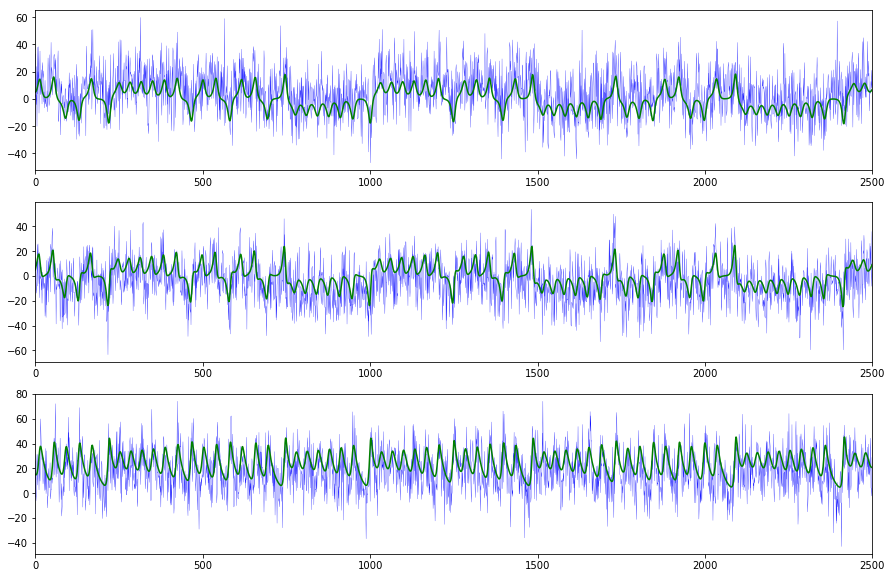

In [5]:
figure(figsize = (15,10))
subplot(3,1,1); plot(Y[0,:], 'b', linewidth = 0.25); xlim([0,m])
subplot(3,1,2); plot(Y[1,:], 'b', linewidth = 0.25); xlim([0,m])
subplot(3,1,3); plot(Y[2,:], 'b', linewidth = 0.25); xlim([0,m])

subplot(3,1,1); plot(X[0,:], 'g')
subplot(3,1,2); plot(X[1,:], 'g')
subplot(3,1,3); plot(X[2,:], 'g')

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

optimizer, X_hat_tf, cost = create_computational_graph(Y, t[subsample], Lorenz, method = 'Gauss3', noise_penalty = 'L1')

init = tf.global_variables_initializer()
sess.run(init)

In [7]:
optimizer.minimize(sess)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.001191
  Number of iterations: 10441
  Number of functions evaluations: 10510


In [8]:
X_hat = X_hat_tf.eval()

In [9]:
RMSE = np.sqrt(np.mean((X_hat - X)**2))
print(RMSE)

0.39715870709311524


(array([-30., -20., -10.,   0.,  10.,  20.,  30.]),
 <a list of 7 Text yticklabel objects>)

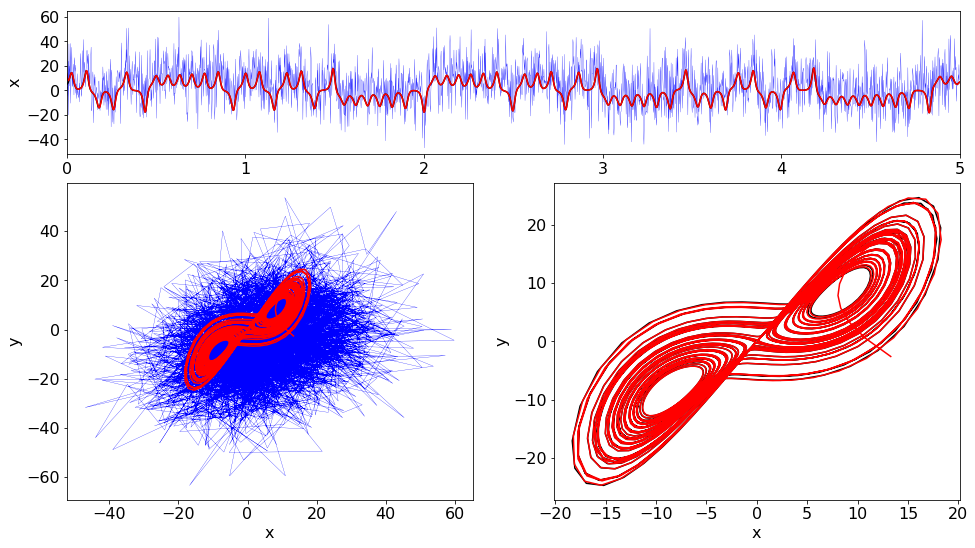

In [10]:
figure(figsize = (16,9))

end = 2500

ax = subplot2grid((3,2),(0, 0), colspan=2, rowspan=1)
plot(t[:end], Y[0,:end], 'b', linewidth = 0.25)
plot(t[:end], X[0,:end], 'k')
plot(t[:end], X_hat[0,:end], 'r')
# xlabel('Time', fontsize = 16)
ylabel('x', fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)
xlim([0,5])

if True:
    ax = subplot2grid((3,2),(1, 0), colspan=1, rowspan=2)
    plot(Y[0,:], Y[1,:], 'b', linewidth = 0.25)
    plot(X_hat[0,:], X_hat[1,:], 'r')
    xlabel('x', fontsize = 16)
    ylabel('y', fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)

else:
    ax = subplot2grid((3,2),(1, 0), colspan=1, rowspan=1)
    plot(t[:end], Y[1,:end], 'b', linewidth = 0.5)
    plot(t[:end], X[1,:end], 'k')
    plot(t[:end], X_hat[1,:end], 'r')
    ylabel('y', fontsize = 16)
    xticks(fontsize = 0)
    yticks(fontsize = 16)
    xlim([0,0.5])
    
    ax = subplot2grid((3,2),(2, 0), colspan=1, rowspan=1)
    plot(t[:end], Y[2,:end], 'b', linewidth = 0.5)
    plot(t[:end], X[2,:end], 'k')
    plot(t[:end], X_hat[2,:end], 'r')
    xlabel('t', fontsize = 16)
    ylabel('z', fontsize = 16)
    xticks(fontsize = 16)
    yticks(fontsize = 16)
    xlim([0,0.5])

ax = subplot2grid((3,2),(1, 1), colspan=1, rowspan=2)
plot(X[0,:], X[1,:], 'k')
plot(X_hat[0,:], X_hat[1,:], 'r')
xlabel('x', fontsize = 16)
ylabel('y', fontsize = 16)
xticks(fontsize = 16)
yticks(fontsize = 16)